# Comparing the impact of various criteria on the brain path algorithm efficiency.

In [1]:
import torch
from utils import device # detects whether you are using CPU or GPU
import matplotlib.pyplot as plt
from cust_plot import plot_rewards, plot_success, plot_mu, plot_sig
import numpy as np
import glob, os
import re

In [2]:
import pandas as pd

In our experiments we compute the pathway by navigating to a node according to a weighted combination of criteria, defined below.

In [3]:
criteria = ['streamlines','node_str','target_node','target_region','hub','neighbour_just_visited_node','edge_con_diff_region','inter_regional_connections','prev_visited_region','target_func_region','edge_con_diff_func_region','prev_visited_func_region']

## Main functions

This section is defining some functions to run the experiments. Namely, for a given brain and a given set of criteria, we read the results of an experiment. We then collate these results by brain, by batch, and by sets of criteria.

In [4]:
def process_brainexperiment(brain,exp, batch, n_av=1000):
    """
    Read the results for a single experiment.

    Return a list of four values: the mean reward, the mean success rate, the mean μ and the mean σ.
    """
    file = f"../R{exp:02}_sl_ns_{brain}_{batch}.pt"
    if os.path.isfile(file):
        tr_data = torch.load(file, map_location=device)
        reward_list = tr_data['rewards']
        success_list = tr_data['success']
        mu_list = tr_data['mu']
        mu_scale = abs(np.array(mu_list)).sum(axis=0)
        mu_list = mu_list / mu_scale
        sigma_list = tr_data['sig']
        sigma_list = sigma_list / mu_scale
        
        reward_max = np.max(reward_list[-n_av:])
        success_max = np.max(success_list[-n_av:])
        #mu_mean = np.mean(mu_list[:][-n_av:],axis=1)
        #sigma_mean = np.mean(sigma_list[:][-n_av:],axis=1) 
        return [reward_max,success_max]#,mu_mean,sigma_mean]
    else:
        return [np.NaN,np.NaN]#,[],[]]

In [5]:
def process_brain(brain,batch,n_av = 1000):
    """
    Compile all the experiments for a given brain and a given batch. These experiments consist of removing one criterion at a time and compute the weights maximising the average efficiencies of the paths.
    """
    results = [process_brainexperiment(brain, exp, batch, n_av) for exp in range(1,14)]
    return results

In [6]:
def get_brain_efficiencies(brain, batch, n_av = 1000):
    """
    Compute the efficiencies for a given brain, for each set of criteria.
    """
    results = process_brain(brain,batch, n_av)
    efficiencies = np.array([r[0] for r in results])
    scaledefficiencies = 1 - efficiencies/efficiencies[0]
    return {criteria[i]: v  for (i,v) in enumerate(scaledefficiencies[1:])}

In [7]:
def process_batch(batch):
    """
    Compile a dict containing the efficiency results for each brain in a batch of experiments.
    """
    flist = glob.glob(f"../R*{batch}.pt")
    brainlist = np.unique(np.sort([int(re.findall(r'\d+',file)[1]) for file in flist]))
    efficiencies = {}
    for brain in brainlist:
        efficiencies[brain] = get_brain_efficiencies(brain,batch)
    return efficiencies

In [8]:
def compare_brain_by_batch(brain):
    flist = glob.glob(f"../R*_{brain}_*.pt")
    batchlist = np.unique(np.sort([int(re.findall(r'\d+',file)[2]) for file in flist]))
    efficiencies = {}
    for batch in batchlist:
        efficiencies[batch] = get_brain_efficiencies(brain,batch)
    return efficiencies

In [9]:
def compare_everything():
    """
    Compile the results of all the experiments we have. This function returns a dict of dicts of dicts. 
    At the higher level are the batches, then middle level the brains and finally the criteria.
    """
    flist = glob.glob(f"../R*_*.pt")
    batchlist = np.unique(np.sort([int(re.findall(r'\d+',file)[2]) for file in flist]))
    print(batchlist)
    efficiencies = {}
    for batch in batchlist:
        print(batch)
        efficiencies[batch] = process_batch(batch)
    return efficiencies

In [10]:
def compile_data():
    """
    Compile a pandas dataframe containing the results of all the experiments.
    """
    results = compare_everything()
    res = {k:pd.DataFrame(results[k]) for k in results}
    for k in res:
        head = pd.MultiIndex.from_arrays([[k]*res[k].shape[1],res[k].columns])
        res[k].columns = head
    df = pd.concat([res[k] for k in res],axis=1)
    return df

In [11]:
def update_data(recompute=False):
    """
    Update the data and the excel spreadsheet.
    """
    if recompute:
        df = compile_data()
        df.to_excel("results_max.xlsx")
        batchlist = df.columns.get_level_values(0).unique().values
        with pd.ExcelWriter('results_max_by_batch.xlsx') as writer:
            for batch in batchlist:
                df.loc(axis=1)[batch,:].to_excel(writer,sheet_name=f"{batch}")
    else:
        df = pd.read_excel("results_max.xlsx",header=[0,1],index_col=[0])
    return df

## Analysis

In this section we perform an analysis of the data.

The main structure is a pandas dataframe `df` computed using the function `compute_data` (see previous section). By default this function reads the results from an excel spreadsheet ("results.xlsx"), though it can be made to recompute all the data by calling `df = compute_data(recompute=True)`. Recomputing the dataframe takes time and is only necessary if new data has been created.

The dataframe `df` contains the criteria efficiency for each experiment (each brain, batch and criteria). There are two column headers: the batches and the brain, and one row index: the criteria. It is therefore possible to access the efficiency for each individual criterion, and is also possible to compile results per individual brain, individual batch and/or individual criterion.

For example:
``` {python}
> # access all the data for Brain 3:
> df.loc(axis=1)[:,3]

> # access all the data for Batch 98:
> df.loc(axis=1)[98,:]


> # access all the data for streamlines:
> df.loc(axis=0)["streamlines"]

> # access the efficiency for the `streamlines` criterion for brain 3 in batch 95:
> df.loc["streamlines"][95,3]
```

The efficiencies are computed using the following formula:

$$\mathrm{eff}(c) = 1-r_c/r,$$
where $r$ is the reward achieved using all the criteria, and $r_c$ the reward achieved using all criteria except criterion $c$.

In [12]:
df = update_data(recompute=True)

[94 95 98 99]
94
95
98
99


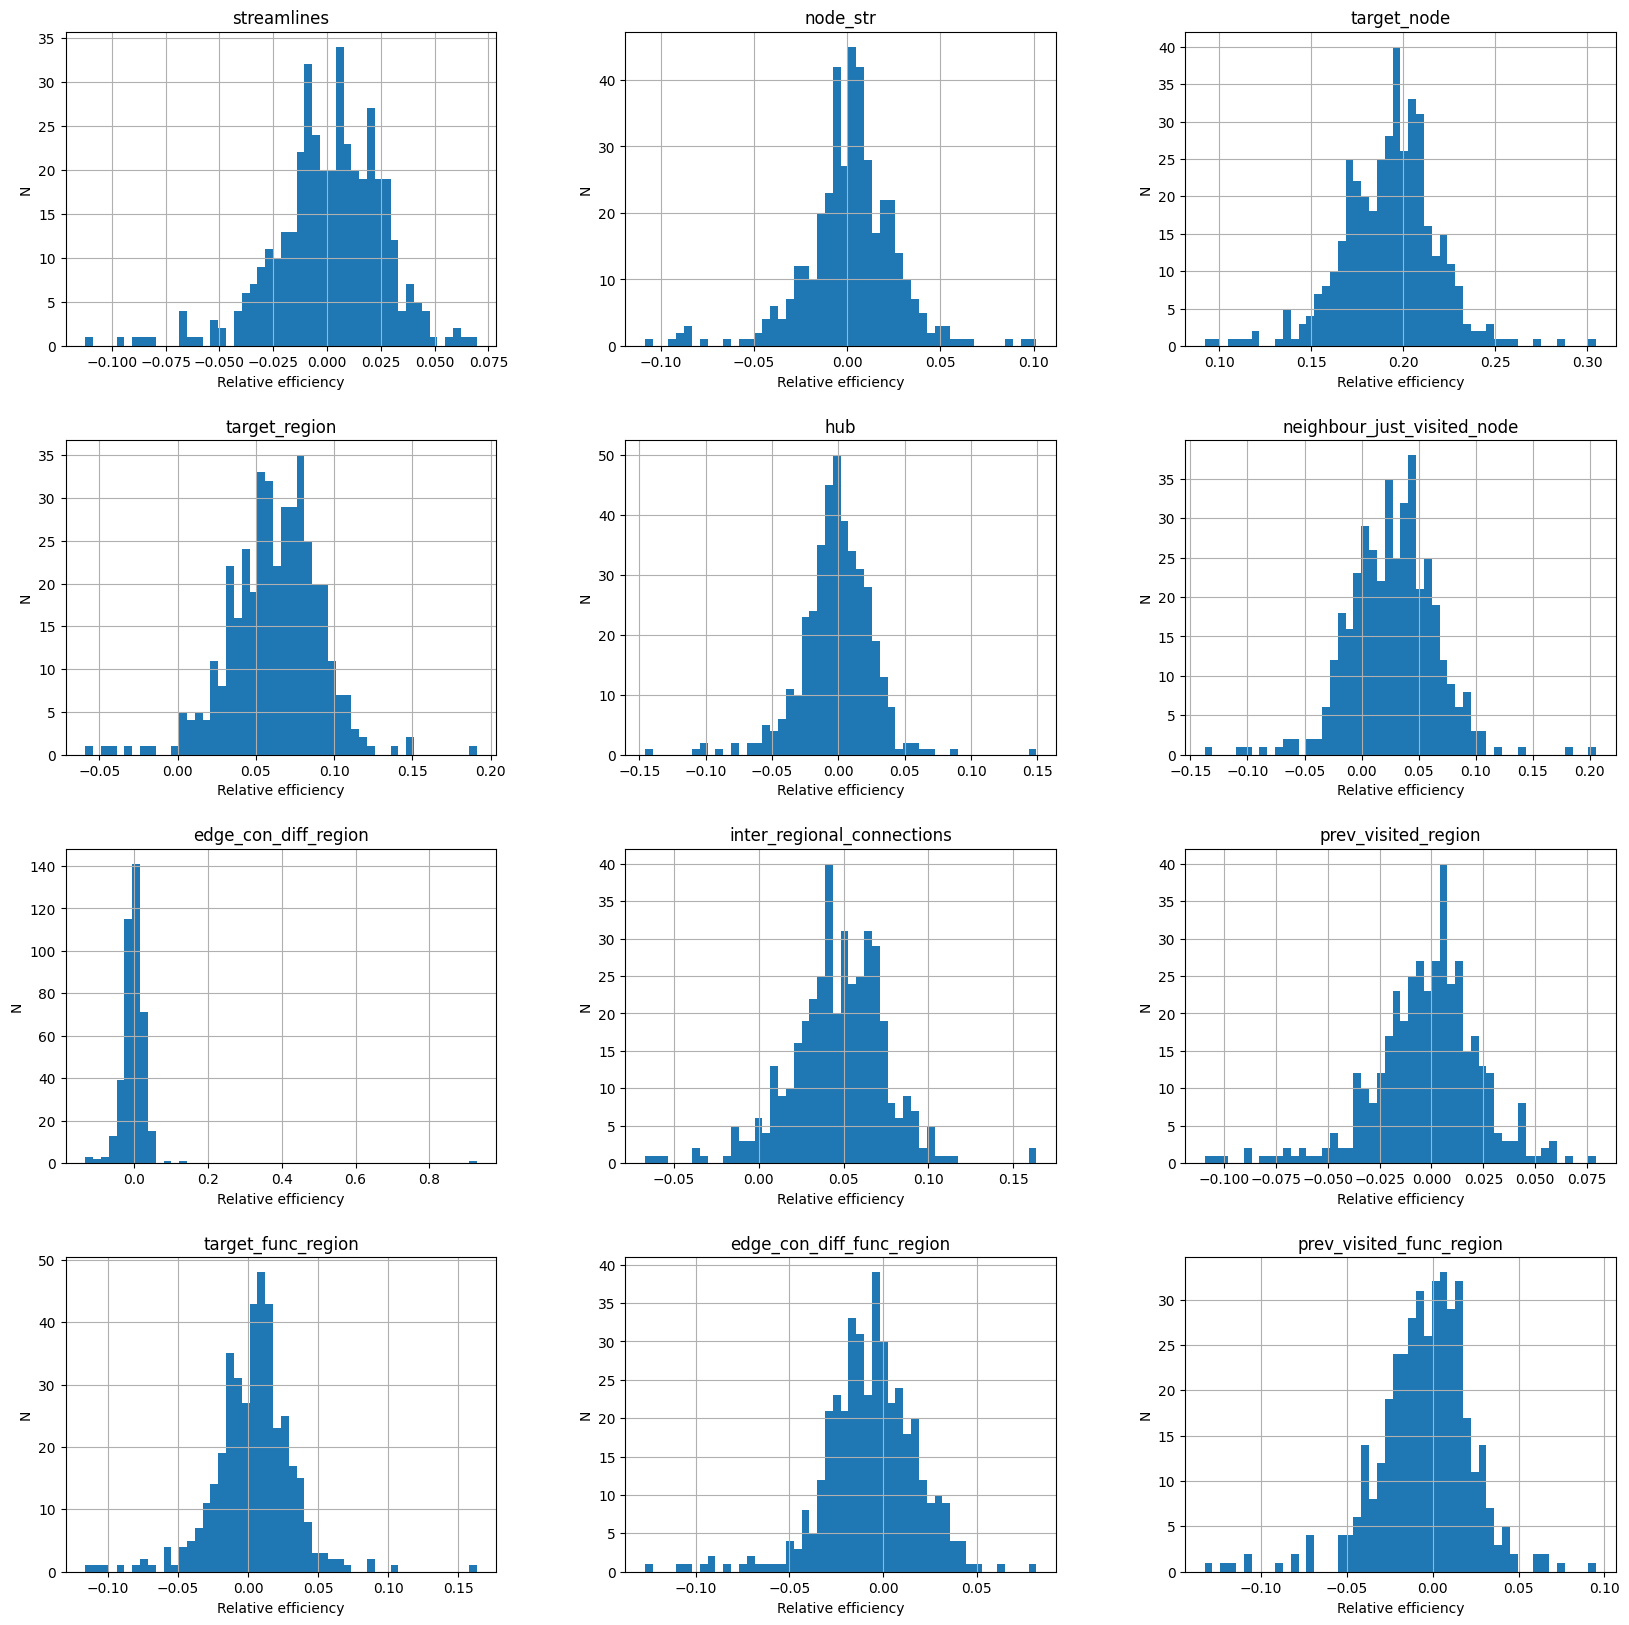

In [16]:
p1 = df.T.hist(figsize=(20,20),bins=50);
for p2 in p1:
    for p in p2:
        p.set_ylabel("N")
        p.set_xlabel("Relative efficiency")
plt.savefig("histograms.pdf")

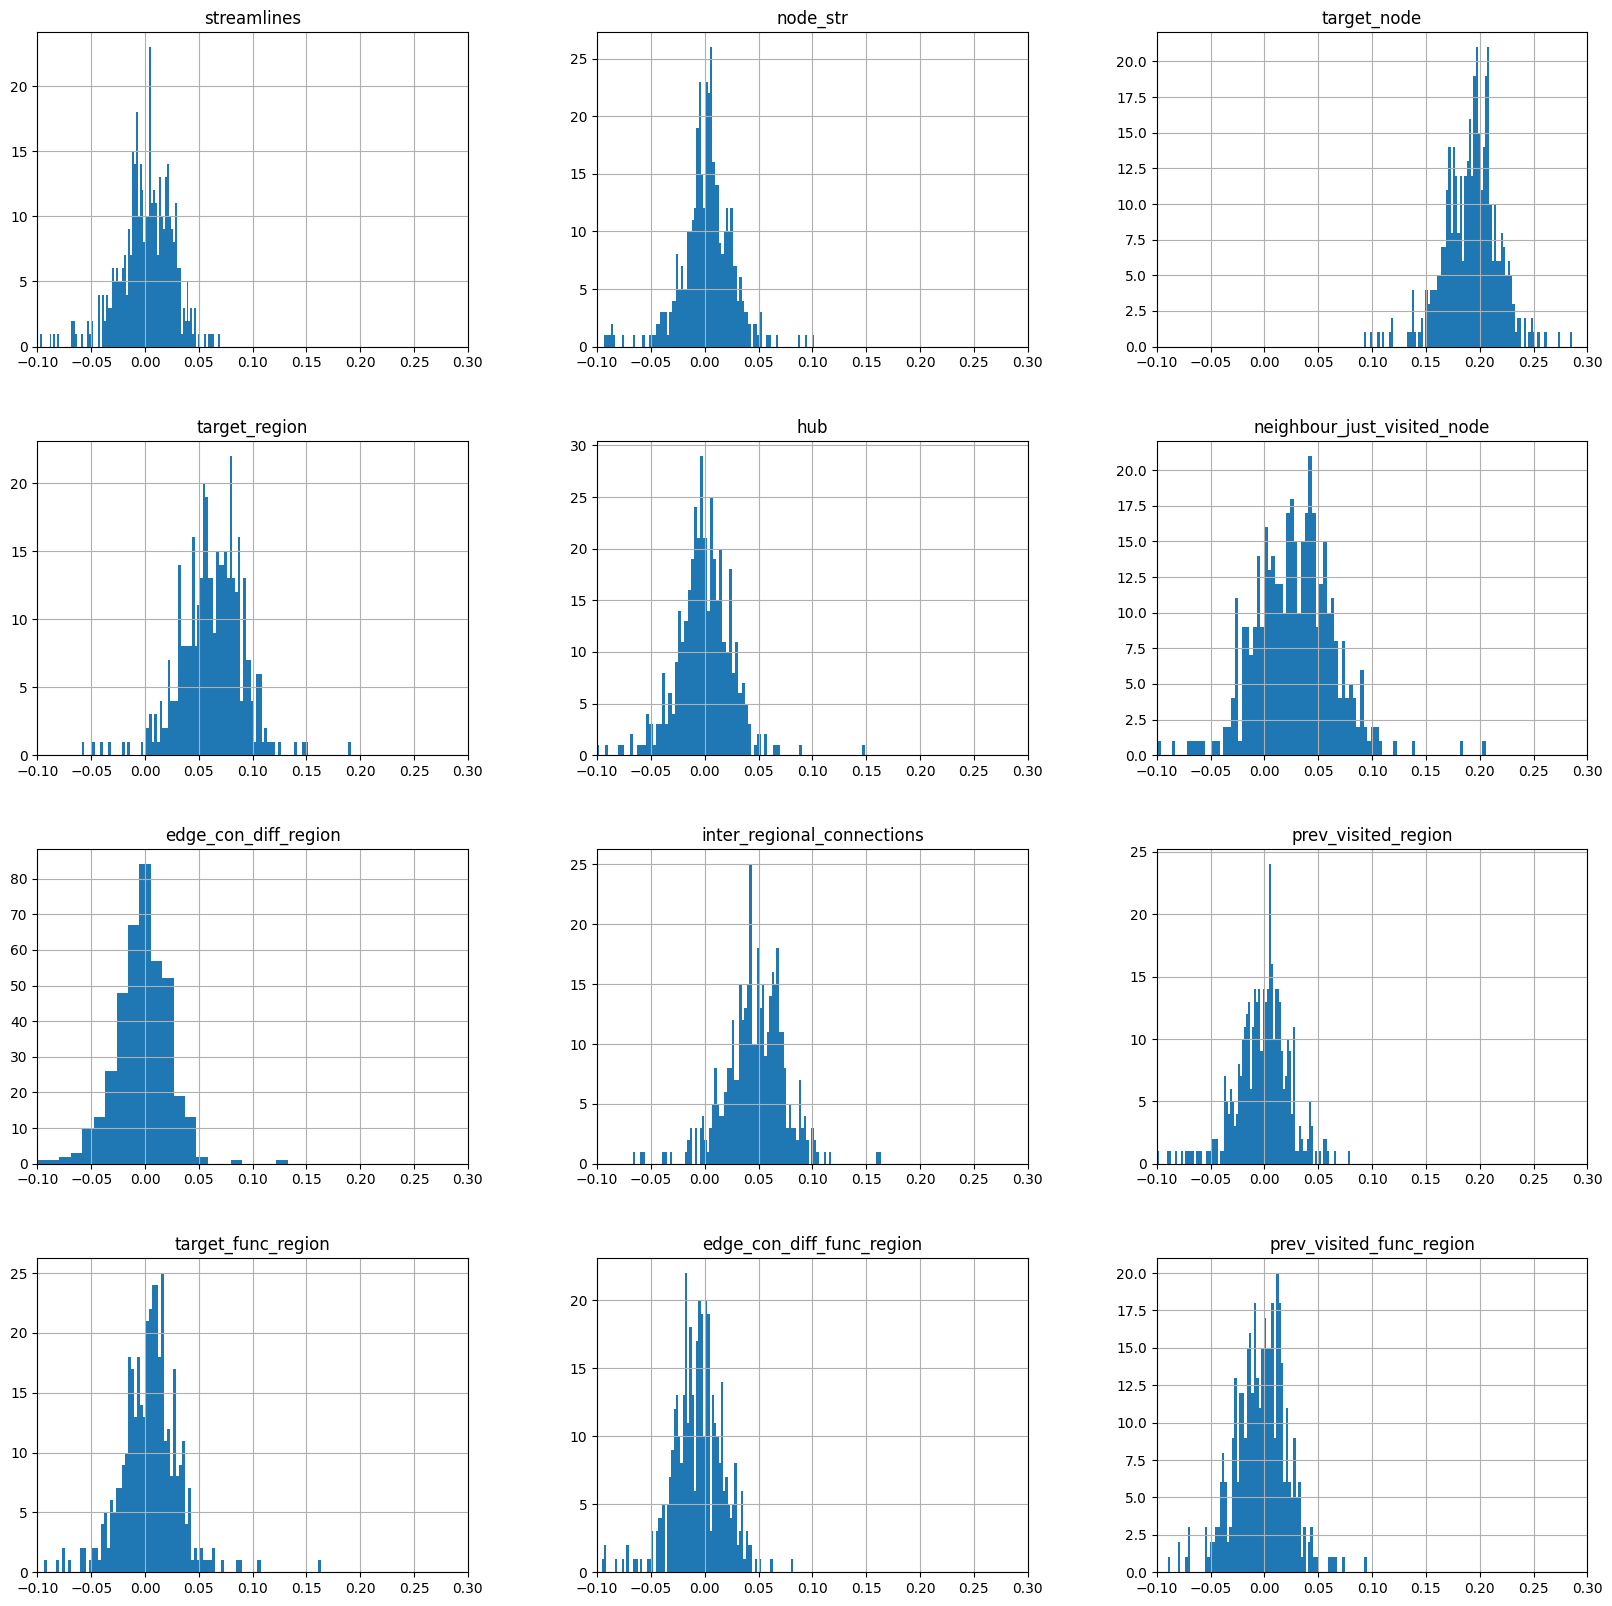

In [14]:
p1 = df.T.hist(figsize=(20,20),bins=100);
for p2 in p1:
    for p in p2:
        p.set_xlim([-0.1,0.3])
plt.savefig("histograms.png")

In [15]:
df_by_batch = df.stack(level=0)

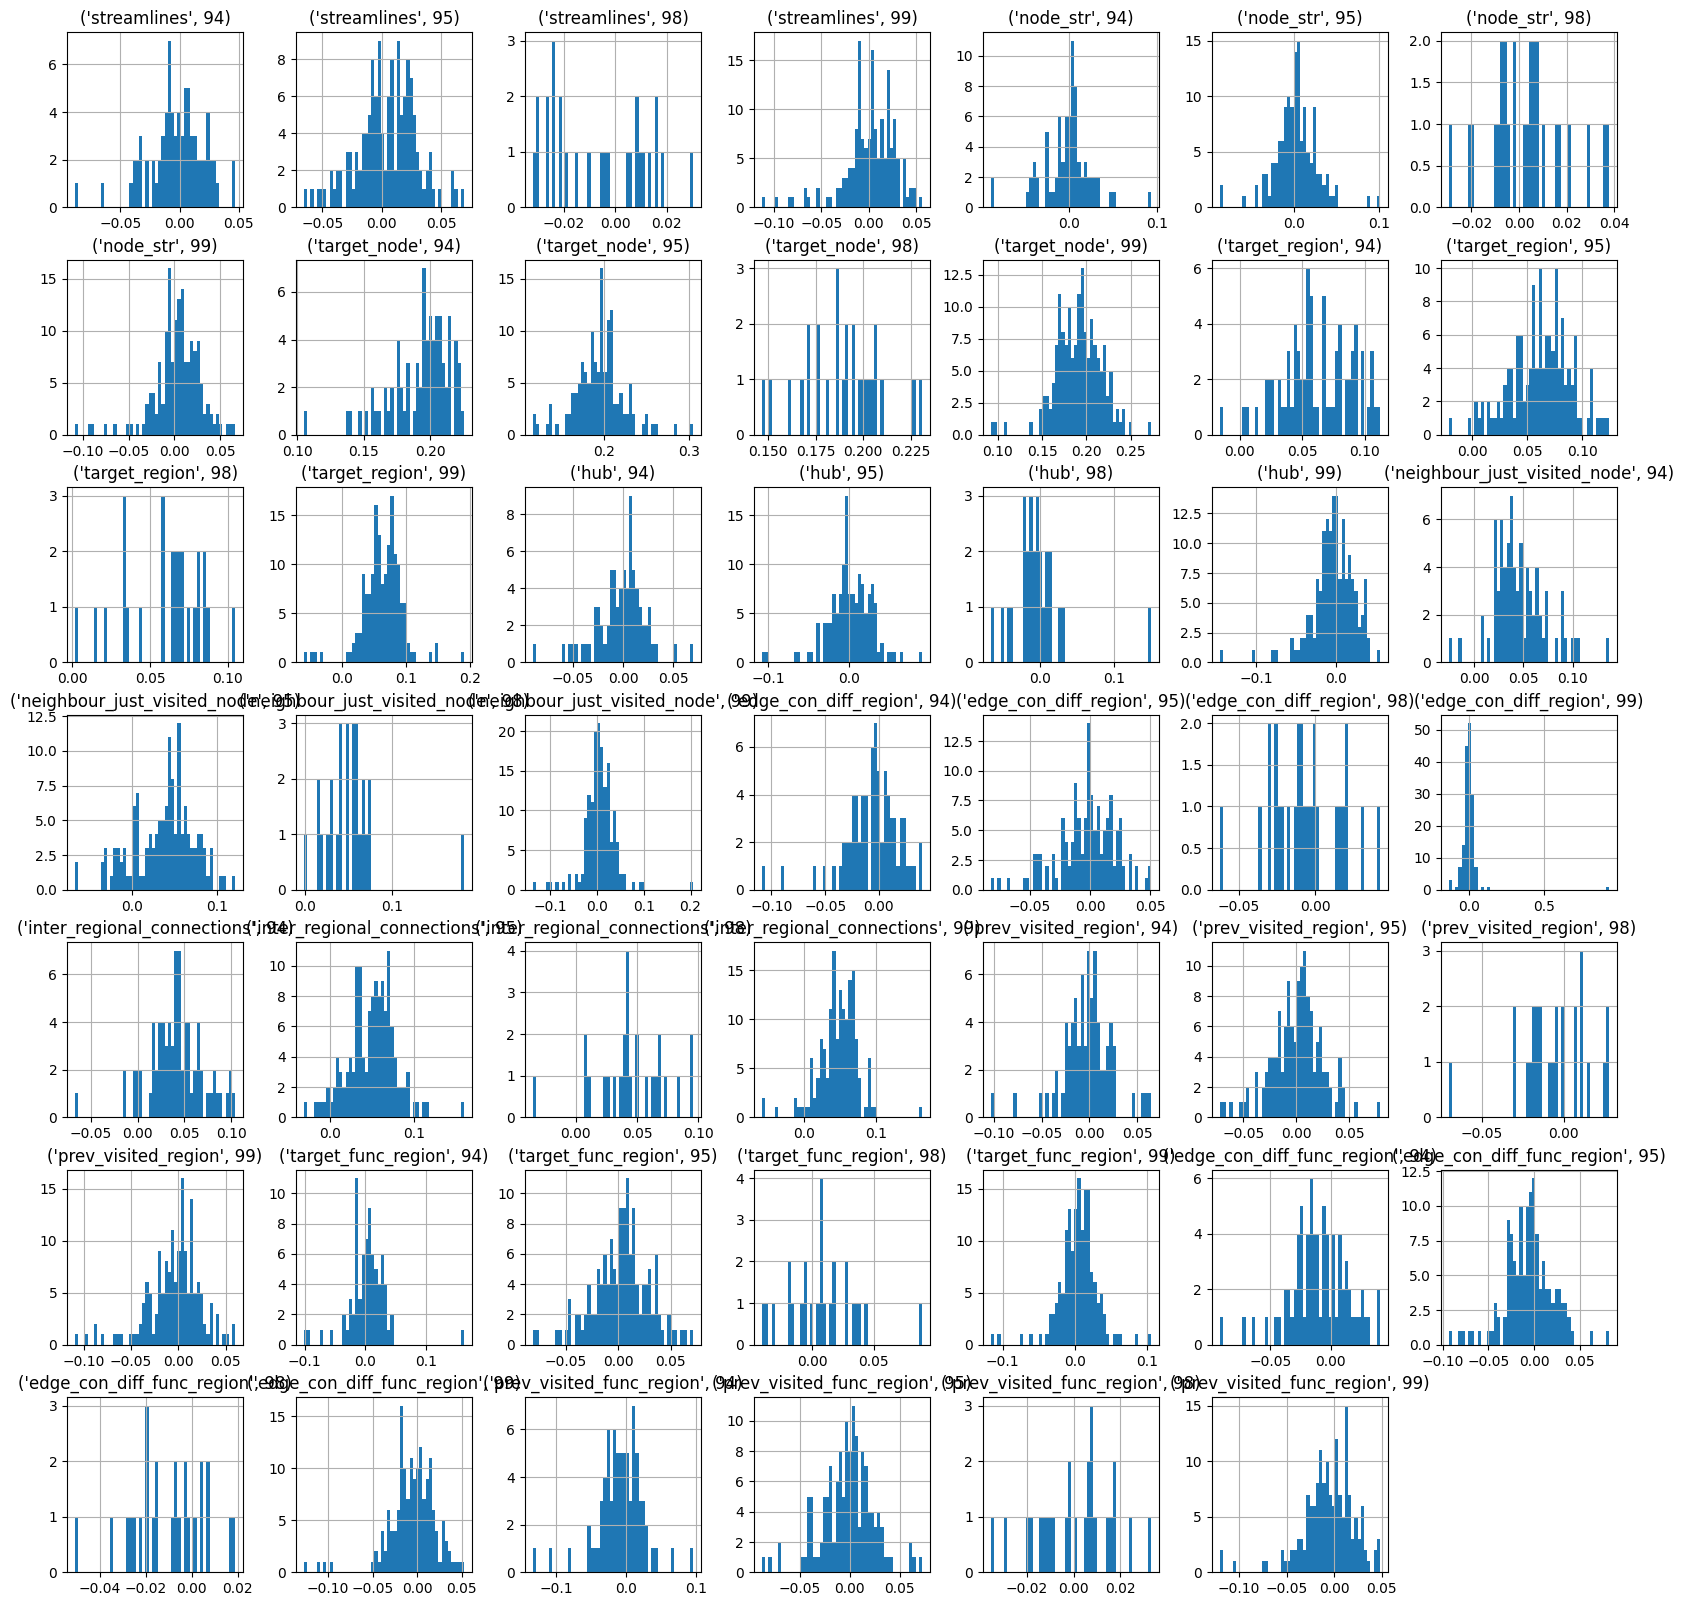

In [16]:
df_by_batch.T.hist(figsize=(20,20),bins=50);

In [17]:
df_by_batch.T.describe().T

count      mean       std       min       25%  \
streamlines                 94   78.0 -0.002406  0.023207 -0.088255 -0.013667   
                            95  139.0  0.004280  0.025096 -0.065465 -0.009339   
                            98   27.0 -0.006441  0.018336 -0.032083 -0.023809   
                            99  162.0  0.001151  0.026909 -0.112333 -0.010638   
node_str                    94   78.0 -0.002369  0.027062 -0.089907 -0.012416   
                            95  139.0  0.002291  0.025141 -0.086957 -0.009668   
                            98   27.0  0.003252  0.015918 -0.029443 -0.006071   
                            99  162.0  0.003056  0.025744 -0.108382 -0.007241   
target_node                 94   78.0  0.192697  0.022892  0.105027  0.178684   
                            95  139.0  0.194324  0.028843  0.115620  0.178352   
                            98   27.0  0.189199  0.020380  0.146699  0.175985   
                            99  162.0  0.191212  0.026249  0.092077  0.173977   
target_region               94   77.0  0.061642  0.027909 -0.015695  0.044925   
                            95  139.0  0.062096  0.026965 -0.021262  0.044636   
                            98   27.0  0.059899  0.024686  0.001960  0.039962   
                            99  162.0  0.063727  0.031228 -0.058918  0.049481   
hub                         94   77.0 -0.002502  0.024453 -0.089925 -0.013052   
                            95  139.0  0.001113  0.027395 -0.107909 -0.010614   
                            98   27.0 -0.004294  0.037697 -0.066641 -0.019249   
                            99  162.0 -0.003004  0.026854 -0.145836 -0.014454   
neighbour_just_visited_node 94   77.0  0.046590  0.026816 -0.025729  0.029085   
                            95  139.0  0.037152  0.035344 -0.067076  0.012017   
                            98   27.0  0.051368  0.033135 -0.001708  0.033953   
                            99  162.0  0.005647  0.034845 -0.137531 -0.008649   
edge_con_diff_region        94   77.0 -0.006123  0.025398 -0.108905 -0.020814   
                            95  139.0 -0.002747  0.024053 -0.082161 -0.013818   
                            98   27.0 -0.006394  0.022592 -0.062432 -0.021593   
                            99  162.0  0.002795  0.079467 -0.132516 -0.017825   
inter_regional_connections  94   77.0  0.040751  0.029167 -0.067082  0.024514   
                            95  139.0  0.049362  0.028649 -0.031292  0.032434   
                            98   26.0  0.045153  0.028819 -0.035094  0.033731   
                            99  161.0  0.047313  0.027439 -0.058311  0.034956   
prev_visited_region         94   77.0 -0.002670  0.025902 -0.103269 -0.014760   
                            95  139.0  0.000574  0.023940 -0.072109 -0.012922   
                            98   26.0 -0.006038  0.021271 -0.069978 -0.018376   
                            99  161.0 -0.004088  0.027804 -0.109219 -0.017886   
target_func_region          94   77.0  0.002501  0.032638 -0.100908 -0.012959   
                            95  139.0  0.002966  0.026812 -0.081035 -0.013729   
                            98   26.0  0.007683  0.028343 -0.041165 -0.008499   
                            99  161.0  0.004690  0.026908 -0.116283 -0.008167   
edge_con_diff_func_region   94   77.0 -0.010327  0.024087 -0.091596 -0.025039   
                            95  139.0 -0.005978  0.026312 -0.093291 -0.021044   
                            98   26.0 -0.010454  0.016192 -0.050941 -0.020035   
                            99  161.0 -0.005338  0.026256 -0.127079 -0.017843   
prev_visited_func_region    94   77.0 -0.007815  0.032708 -0.132940 -0.025026   
                            95  139.0 -0.002515  0.026376 -0.088074 -0.018291   
                            98   26.0  0.000319  0.016292 -0.035196 -0.010771   
                            99  161.0 -0.005711  0.027282 -0.120160 -0.019066   

                                     50%       75%       max  

/var/folders/vn/0jxbshdd183c2dnj6_0qkcpw0000gn/T/ipykernel_55810/624578205.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  axarr = pd.plotting.scatter_matrix(df.T, ax = plt.gca());


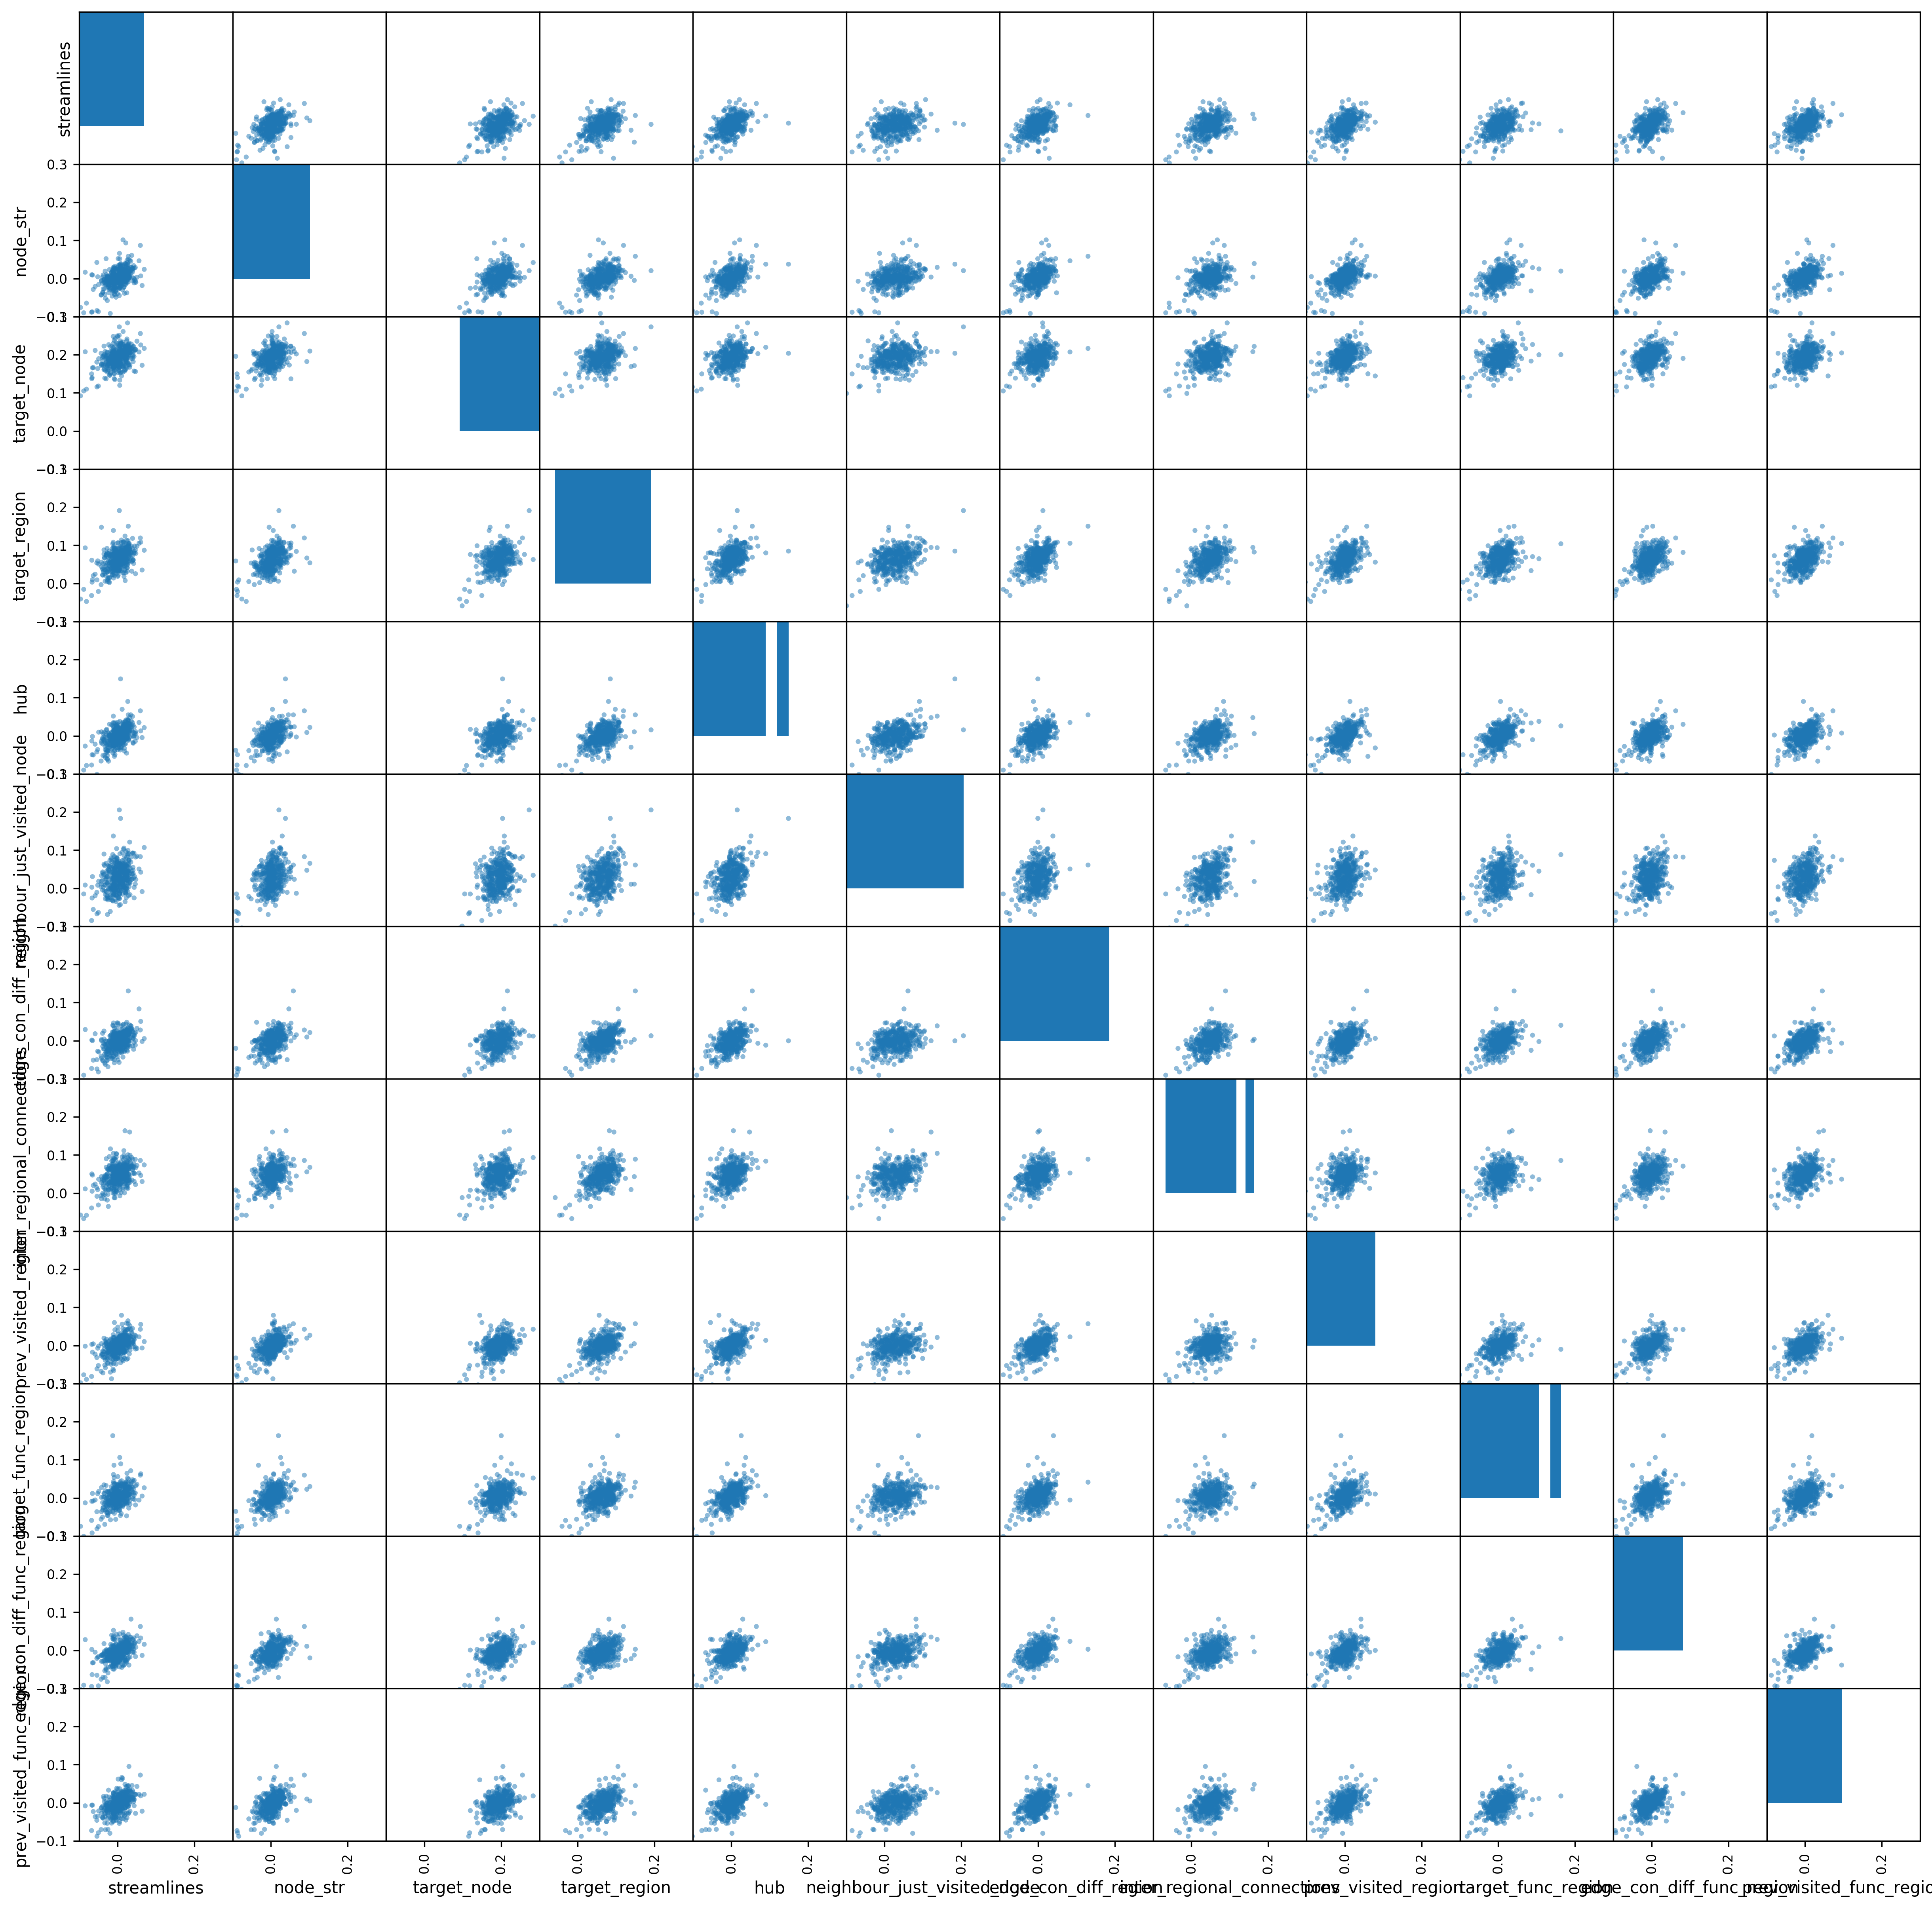

In [18]:
fig = plt.figure(dpi=300, figsize=(20,20))
axarr = pd.plotting.scatter_matrix(df.T, ax = plt.gca());
for i in range(12):
    for j in range(12):
        axarr[i,j].set_xlim(-0.1,0.3)
        axarr[i,j].set_ylim(-0.1,0.3)
plt.savefig("scatter_matrix.png")

In [19]:
results_brain = process_batch(99)

df = pd.DataFrame({key: {criteria[i-1] : results_brain[key][i] for i in range(1,13)} for key in results_brain})

df.T.hist()

KeyError: 1

In [ ]:
results_02 = compare_brain_by_batch(2)

df = pd.DataFrame({key: {criteria[i-1] : results_02[key][i] for i in range(1,13)} for key in results_02})

df.T.hist()

In [ ]:
df.T.hist(figsize=(20,15))

In [ ]:
os.path.isfile("blah")

In [ ]:
np.NaN